In this section, we build the Steam game recommendation system based on *TensorFlow's matrix decomposition algorithm*. Here are its main steps and methods:

1. **Data loading and preprocessing**:
   - Load data in JSON format using Pandas, clean and process the data.
   - Convert user IDs and game names to serialized IDs and save them as dictionaries.

2. **Construct sparse matrices**:
   - Create a user-game purchase matrix and a user-game play length matrix.
   - Filter the purchasers based on the number of games purchased by users and randomly divide the training set, validation set and test set.

3. **Model building**:
   - A recommendation model based on matrix decomposition is built using TensorFlow.
   - The model uses a matrix of hidden features of users and games, and considers the bias terms of users and games.
   - A confidence parameter is introduced to adjust the user's preference based on the game duration.

4. **Model Training and Optimization**:
   - The Adagrad optimizer is used to optimize the model parameters by minimizing the loss function.
   - During the training process, the accuracy of the model on the training and validation sets is monitored and the loss values are output.

5. **Evaluate the model**:
   - Evaluate the accuracy of the model using the validation set and adjust the hyperparameters to improve the model performance.
   - Finally evaluate the model performance on the test set.

6. **Recommended Games**:
   - Generate a list of recommended games for a specified user based on the trained model.
   - Compare the recommended games with the games actually purchased by the user and calculate the recommendation accuracy. 7.

7. **Result visualization**:
   - Using Matplotlib, we plotted the change curves of loss value and accuracy rate during the training process.

In [2]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import seaborn as sns
import random
from collections import Counter
from sklearn.metrics import roc_curve, auc, average_precision_score
import joblib
import os
import pandas as pd
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Directory path
directory_path = "/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/games_clean.json"

# List all files in the given directory
files = [f for f in os.listdir(directory_path) if f.endswith('.json') and f.startswith('part')]

# Create an empty DataFrame
df = pd.DataFrame()

# Read each file and append it to the DataFrame
for file in files:
    file_path = os.path.join(directory_path, file)
    file_df = pd.read_json(file_path, lines=True)
    df = pd.concat([df, file_df], ignore_index=True)
    
# # Read each file and append it to the DataFrame, filtering out samples with playtime_forever equal to 0
# for file in files:
#     file_path = os.path.join(directory_path, file)
#     file_df = pd.read_json(file_path, lines=True)
#     # Filter out samples with playtime_forever equal to 0
#     file_df = file_df[file_df['playtime_forever'] != 0]
#     df = pd.concat([df, file_df], ignore_index=True)
#     
df.head()


,steamid,appid,name,playtime_forever
0,76561197975693312,220,Half-Life 2,926
1,76561197975693312,240,Counter-Strike: Source,255
2,76561197975693312,320,Half-Life 2: Deathmatch,0
3,76561197975693312,340,Half-Life 2: Lost Coast,10
4,76561197975693312,2400,The Ship,124


In [4]:
# Data processing
df['UserID'] = df['steamid'].astype(int)
df['Game'] = df['name'].astype(str)
df['Hours_Played'] = df['playtime_forever'].astype('float32')

# Sorting
df.UserID = df.UserID.astype('int')
df = df.sort_values(['UserID', 'Game', 'Hours_Played'])

# Organize into a new DataFrame clean_df
clean_df = df.drop_duplicates(['UserID', 'Game'], keep='last').drop(['steamid', 'name', 'playtime_forever', 'appid'], axis=1)
clean_df.count()


UserID          5270565
Game            5270565
Hours_Played    5270565
dtype: int64

In [5]:
n_users = len(clean_df.UserID.unique())
n_games = len(clean_df.Game.unique())
print('There are {0} users and {1} games in the user-game dataset.'.format(n_users, n_games))


There are 4712 users and 38480 games in the user-game dataset.


In [6]:
# Calculate the sparsity of the matrix
sparsity = clean_df.shape[0] / float(n_users * n_games)
print('The percentage of valid data in the user-game matrix is: {:.2%}'.format(sparsity))


The percentage of valid data in the user-game matrix is: 2.91%


In [7]:
# Establish serialized IDs for convenience

# Dictionary mapping user IDs to serialized user IDs
user2idx = {user: i for i, user in enumerate(clean_df.UserID.unique())}
# Dictionary mapping serialized user IDs to user IDs
idx2user = {i: user for user, i in user2idx.items()}

# Dictionary mapping game names to serialized game IDs
game2idx = {game: i for i, game in enumerate(clean_df.Game.unique())}
# Dictionary mapping serialized game IDs to game names
idx2game = {i: game for game, i in game2idx.items()}

# Save the dictionaries for PyQt5 usage
# joblib.dump(idx2game, '/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/idx2game.pkl')
# joblib.dump(game2idx, '/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/game2idx.pkl')


In [8]:
# Serialized user ID - serialized game ID - game duration
user_idx = clean_df['UserID'].apply(lambda x: user2idx[x]).values
game_idx = clean_df['gamesIdx'] = clean_df['Game'].apply(lambda x: game2idx[x]).values
hours = clean_df['Hours_Played'].values

# Save the game duration matrix
hours_save = np.zeros(shape=(n_users, n_games))
for i in range(len(user_idx)):
    hours_save[user_idx[i], game_idx[i]] = hours[i]
    
# joblib.dump(hours_save, '/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/hours.pkl')


In [9]:
# Create sparse matrices to store the large dataset
# Confidence matrix: Increase confidence based on game duration, minimum is 1

zero_matrix = np.zeros(shape=(n_users, n_games))
# Purchase matrix
user_game_pref = zero_matrix.copy()
user_game_pref[user_idx, game_idx] = 1

# Save the purchase matrix
# joblib.dump(user_game_pref, '/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/buy.pkl')

# Confidence matrix
user_game_interactions = zero_matrix.copy()
user_game_interactions[user_idx, game_idx] = hours + 1


In [10]:
k = 5
# For each user, calculate the number of games they purchased
purchase_counts = np.apply_along_axis(np.bincount, 1, user_game_pref.astype(int))
buyers_idx = np.where(purchase_counts[:, 1] >= 2 * k)[0]  # Set of buyers who purchased more than 2*k games

print('{0} players have purchased at least {1} games'.format(len(buyers_idx), 2 * k))

# Save list of effective buyers
#joblib.dump(buyers_idx, '/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/buyers.pkl')

4701 players have purchased at least 10 games


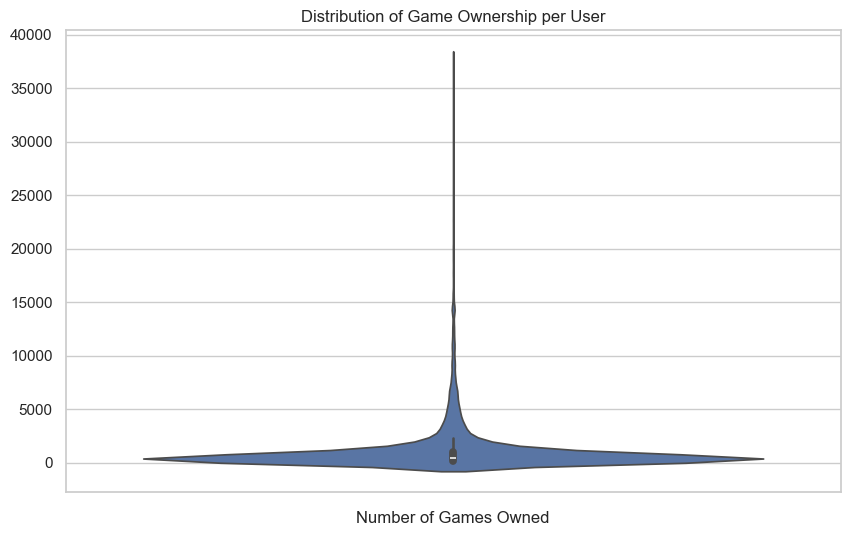

Statistics about game ownership per user:
-----------------------------------------
Mean number of games owned per user: 1118.54
Median number of games owned per user: 431.00
Maximum number of games owned by a user: 37634
Minimum number of games owned by a user: 1


In [11]:
# Calculate the number of games owned by each user
ownership_counts = np.apply_along_axis(np.bincount, 1, user_game_pref.astype(int))[:, 1:]  # Exclude the count of zeros
total_ownership = np.sum(ownership_counts, axis=1)
max_ownership = np.max(total_ownership)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a violin plot to visualize the distribution of game ownership
plt.figure(figsize=(10, 6))
sns.violinplot(total_ownership, inner="box")
plt.xlabel('Number of Games Owned')
plt.title('Distribution of Game Ownership per User')
plt.show()

# Output statistics about game ownership
print('Statistics about game ownership per user:')
print('-----------------------------------------')
print('Mean number of games owned per user: {:.2f}'.format(np.mean(total_ownership)))
print('Median number of games owned per user: {:.2f}'.format(np.median(total_ownership)))
print('Maximum number of games owned by a user: {}'.format(np.max(total_ownership)))
print('Minimum number of games owned by a user: {}'.format(np.min(total_ownership)))


In [12]:
test_frac = 0.2  # 20% of the data for testing, 20% of the data for validation

test_users_idx = np.random.choice(buyers_idx, 
                                  size=int(np.ceil(len(buyers_idx) * test_frac)), 
                                  replace=False)
val_users_idx = test_users_idx[:int(len(test_users_idx) / 2)]
test_users_idx = test_users_idx[int(len(test_users_idx) / 2):]

In [13]:
# Mask k games in the training set
def data_process(dat, train, test, user_idx, k):
    for user in user_idx:
        purchases = np.where(dat[user, :] == 1)[0]
        mask = np.random.choice(purchases, size=k, replace=False)
        train[user, mask] = 0
        test[user, mask] = dat[user, mask]
    return train, test


In [14]:
train_matrix = user_game_pref.copy()
test_matrix = zero_matrix.copy()
val_matrix = zero_matrix.copy()

train_matrix, val_matrix = data_process(user_game_pref, train_matrix, val_matrix, val_users_idx, k)
train_matrix, test_matrix = data_process(user_game_pref, train_matrix, test_matrix, test_users_idx, k)

In [15]:
test_matrix[test_users_idx[0], test_matrix[test_users_idx[0], :].nonzero()[0]]

array([1., 1., 1., 1., 1.])

In [16]:
train_matrix[test_users_idx[0], test_matrix[test_users_idx[0], :].nonzero()[0]]

array([0., 0., 0., 0., 0.])

In [17]:
tf.reset_default_graph()

# Preference matrix
pref = tf.placeholder(tf.float32, (n_users, n_games))
# Interaction matrix for game time
interactions = tf.placeholder(tf.float32, (n_users, n_games))
user_idx = tf.placeholder(tf.int32, (None))


In [18]:
n_features = 30  # Set the number of hidden features to 30

# X matrix (User - Hidden features) represents user latent preferences
X = tf.Variable(tf.truncated_normal([n_users, n_features], mean=0, stddev=0.05), dtype=tf.float32, name='X')
# Y matrix (Game - Hidden features) represents game latent features
Y = tf.Variable(tf.truncated_normal([n_games, n_features], mean=0, stddev=0.05), dtype=tf.float32, name='Y')

# Initialize confidence parameter
conf_alpha = tf.Variable(tf.random_uniform([1], 0, 1))


In [19]:
# Initialize user bias
user_bias = tf.Variable(tf.truncated_normal([n_users, 1], stddev=0.2))

# Concatenate vectors to the user matrix
X_plus_bias = tf.concat([X,
                         user_bias,
                         tf.ones((n_users, 1), dtype=tf.float32)], 
                        axis=1)


In [20]:
# Initialize game bias
item_bias = tf.Variable(tf.truncated_normal([n_games, 1], stddev=0.2))

# Concatenate vectors to the game matrix
Y_plus_bias = tf.concat([Y,
                         tf.ones((n_games, 1), dtype=tf.float32),
                         item_bias],
                        axis=1)


In [21]:
# Determine the resulting preference matrix through matrix multiplication
pred_pref = tf.matmul(X_plus_bias, Y_plus_bias, transpose_b=True)

# Construct the confidence matrix using game duration and alpha parameter
conf = 1 + conf_alpha * interactions

# Loss function
cost = tf.reduce_sum(tf.multiply(conf, tf.square(tf.subtract(pref, pred_pref))))
l2_sqr = tf.nn.l2_loss(X) + tf.nn.l2_loss(Y) + tf.nn.l2_loss(user_bias) + tf.nn.l2_loss(item_bias)
lambda_c = 0.01
loss = cost + lambda_c * l2_sqr


In [23]:
# Gradient descent algorithm optimizer
lr = 0.05
optimize = tf.train.AdagradOptimizer(learning_rate=lr).minimize(loss)


In [24]:
# Precision calculation optimization, merging base game and DLC into the same game
def precision_dlc(recommendations, labels):
    # Split recommended games by word
    recommendations_split = []
    # Split purchased games by word
    labels_split = []
    for label in labels:
        labels_split.append(idx2game[label].split())
    for game in recommendations:
        recommendations_split.append(idx2game[game].split())
        
    count = 0
    for game in recommendations_split:
        for label in labels_split:
            # When the overlap between recommended games and purchased games words exceeds the threshold, it is considered the same game
            if (len(set(game) & set(label)) / min(len(game), len(label))) > 0.2:
                count += 1
                break
    
    return float(count / len(recommendations))


In [25]:
# Select the top k from the predicted list
def top_k_precision(pred, mat, k, user_idx):
    precisions = []
    for user in user_idx:
        rec = np.argsort(-pred[user, :])
        # Select the top k recommendations based on highest scores
        top_k = rec[:k]
        labels = mat[user, :].nonzero()[0]
        # Calculate precision of recommendations against actual purchases and return
        precision = precision_dlc(top_k, labels)
        precisions.append(precision)
    return np.mean(precisions)


In [ ]:
iterations = 500
# Data for plotting: loss and training set accuracy
fig_loss = np.zeros([iterations])
fig_train_precision = np.zeros([iterations])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(iterations):
        sess.run(optimize, feed_dict={pref: train_matrix, 
                                       interactions: user_game_interactions})
        if i % 10 == 0:
            mod_loss = sess.run(loss, feed_dict={pref: train_matrix,
                                                  interactions: user_game_interactions})
            mod_pred = pred_pref.eval()
            train_precision = top_k_precision(mod_pred, train_matrix, k, val_users_idx)
            val_precision = top_k_precision(mod_pred, val_matrix, k, val_users_idx)
            print('Progress: {}...'.format(i),
                  'Loss: {:.2f}...'.format(mod_loss),
                  'Training set accuracy: {:.3f}...'.format(train_precision),
                  'Validation set accuracy: {:.3f}'.format(val_precision))
        fig_loss[i] = sess.run(loss, feed_dict={pref: train_matrix,
                                                interactions: user_game_interactions})
        fig_train_precision[i] = top_k_precision(mod_pred, train_matrix, k, val_users_idx)
    rec = pred_pref.eval()
    test_precision = top_k_precision(rec, test_matrix, k, test_users_idx)
    print('\n')
    print('Model completed, accuracy: {:.3f}'.format(test_precision))


2024-04-23 19:28:52.351798: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


In [ ]:
n_examples = 5
users = np.random.choice(test_users_idx, size=n_examples, replace=False)
rec_games = np.argsort(-rec)

for user in users:
    purchase_history = np.where(train_matrix[user, :] != 0)[0]
    recommendations = rec_games[user, :]
    new_recommendations = recommendations[~np.in1d(recommendations, purchase_history)][:k]
    
    print('Recommended games for user with ID {0}:'.format(idx2user[user]))
    print(', '.join([idx2game[game] for game in new_recommendations]))
    print('Games actually purchased by the user:')
    print(', '.join([idx2game[game] for game in np.where(test_matrix[user, :] != 0)[0]]))
    print('Accuracy: {:.2f}%'.format(100 * precision_dlc(new_recommendations, np.where(test_matrix[user, :] != 0)[0])))
    print('\n')


In [56]:
# Save the trained rating matrix
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     joblib.dump(pred_pref.eval(), '/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/rec.pkl')


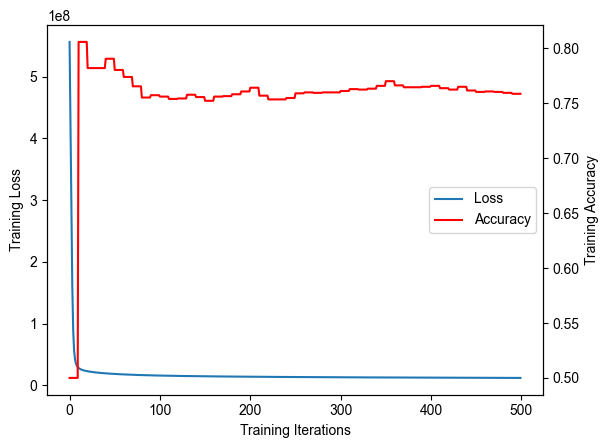

In [59]:

plt.rcParams['font.sans-serif'] = ['Arial']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(np.arange(iterations), fig_loss, label='Loss')
lns2 = ax2.plot(np.arange(iterations), fig_train_precision, 'r', label='Train Accuracy')
ax1.set_xlabel('Training Iterations')
ax1.set_ylabel('Training Loss')
ax2.set_ylabel('Training Accuracy')
# Merge legends
lns = lns1 + lns2
labels = ['Loss', 'Accuracy']
plt.legend(lns, labels, loc=7)
plt.show()
